In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# 1. Обработка данных

Для удобства воспользовалась сервисом https://ctlab.itmo.ru/phantasus/

Данные по экспрессии в нужном формате скачала оттуда.

In [2]:
data_expression = pd.read_csv('GSE26728.gct', sep='\t', skiprows=2)
data_expression = data_expression.drop(columns=['Description'])
data_expression = data_expression.rename(columns={'Name':'ID'})
print(data_expression.shape)
data_expression.head()

(22514, 19)


,ID,liver_control_rep1,liver_control_rep2,liver_control_rep3,liver_control_rep4,liver_control_rep5,liver_control_rep6,liver_BPALowDose_rep1,liver_BPALowDose_rep2,liver_BPALowDose_rep3,liver_BPALowDose_rep4,liver_BPALowDose_rep5,liver_BPALowDose_rep6,liver_BPAHighDose_rep1,liver_BPAHighDose_rep2,liver_BPAHighDose_rep3,liver_BPAHighDose_rep4,liver_BPAHighDose_rep5,liver_BPAHighDose_rep6
0,A_51_P100034,12.630,11.899,12.393,12.539,12.368,12.361,12.332,12.148,12.032,11.955,12.222,12.202,12.107,12.529,11.838,12.054,12.223,12.343
1,A_51_P100063,5.828,6.598,5.984,5.986,6.089,6.163,6.384,6.410,5.984,6.158,6.031,5.833,6.441,7.814,6.107,7.017,5.853,6.656
2,A_51_P100099,7.638,7.635,7.216,7.767,7.516,7.378,7.171,7.558,7.571,7.607,7.523,7.628,7.461,7.321,7.792,7.577,7.412,7.357
3,A_51_P100155,10.947,10.582,10.406,11.054,10.770,10.402,10.610,10.512,10.492,10.485,10.839,10.535,10.674,10.333,10.622,10.302,10.339,10.572
4,A_51_P100174,6.632,6.089,6.012,6.190,6.260,6.131,5.993,6.274,6.002,6.011,6.124,6.062,6.375,6.087,6.152,6.202,6.209,6.172


## 1.1 Мапим айдишники

В этой табличке айдишники генов - внутренние айдишники оборудования (Agilent). Надо сопоставить их с какими-то нормальными айдишниками. Для этого с страницы платформы в GEO скачала еще одну табличку.

In [3]:
data_id = pd.read_csv('GPL7042-9573.txt', sep='\t', skiprows=17)
print(data_id.shape)
data_id.head()

(41174, 17)


,ID,SPOT_ID,CONTROL_TYPE,REFSEQ,GB_ACC,GENE,GENE_SYMBOL,GENE_NAME,UNIGENE_ID,ENSEMBL_ID,TIGR_ID,ACCESSION_STRING,CHROMOSOMAL_LOCATION,CYTOBAND,DESCRIPTION,GO_ID,SEQUENCE
0,A_51_P100021,A_51_P100021,False,NaN,AY454345,16656.0,Hivep3,human immunodeficiency virus type I enhancer b...,Mm.302758,NaN,NaN,gb|AY454345|tc|TC1584815|nap|NAP057482-1,chr4:119807944-119808005,mm|4qD2.1,Mus musculus clone pZAS3 328-2275 zinc finger ...,GO:0003676(nucleic acid binding)|GO:0003677(DN...,CATGGCTGGATTAACGTATGTGTGTGGTATATAGATACACAGAGAG...
1,A_51_P100034,A_51_P100034,False,NM_027162,NM_027162,69674.0,Mif4gd,MIF4G domain containing,Mm.390387,NaN,NaN,ref|NM_027162|ref|NM_001243586|ref|NM_00124358...,chr11:115469328-115469269,mm|11qE2,"Mus musculus MIF4G domain containing (Mif4gd),...",GO:0005488(binding)|GO:0005575(cellular_compon...,GAGACTTTTGTGGAGGAAGCCTGTTTCCTCCAGTCATGAGTGACTG...
2,A_51_P100052,A_51_P100052,False,NM_198863,NM_198863,245450.0,Slitrk2,"SLIT and NTRK-like family, member 2",Mm.336081,ENSMUST00000036043,NaN,ref|NM_198863|ref|NM_001161431|ens|ENSMUST0000...,chrX:63908145-63908204,mm|XqA7.1,"Mus musculus SLIT and NTRK-like family, member...",GO:0003674(molecular_function)|GO:0007409(axon...,CTAAATGTGAATTGCCAAGAAAGGAAGTTCACTAACATCTCTGACC...
3,A_51_P100063,A_51_P100063,False,NM_010727,NM_010727,16924.0,Lnx1,ligand of numb-protein X 1,Mm.440403,NaN,NaN,ref|NM_010727|ref|NM_001159577|ref|NM_00115957...,chr5:74993810-74993386,mm|5qC3.3,Mus musculus ligand of numb-protein X 1 (Lnx1)...,GO:0004842(ubiquitin-protein ligase activity)|...,GAAGAATCAGATGTGGTGACATTCTTCTCGCTGTCAACGGTAGAAG...
4,A_51_P100084,A_51_P100084,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nap|NAP091803-1,unmapped,NaN,NaN,NaN,AAGTCATCTCTCATGCCTATCAGAATACTCTGCCTCTAAGCCCAAA...


Я оставила из этой таблички только то, что похоже на айдишники:

In [4]:
data_id.columns

Index(['ID', 'SPOT_ID', 'CONTROL_TYPE', 'REFSEQ', 'GB_ACC', 'GENE',
       'GENE_SYMBOL', 'GENE_NAME', 'UNIGENE_ID', 'ENSEMBL_ID', 'TIGR_ID',
       'ACCESSION_STRING', 'CHROMOSOMAL_LOCATION', 'CYTOBAND', 'DESCRIPTION',
       'GO_ID', 'SEQUENCE'],
      dtype='object')

In [5]:
data_id = data_id[['ID', 'REFSEQ', 'GB_ACC', 'GENE',
       'GENE_SYMBOL', 'GENE_NAME', 'UNIGENE_ID', 'ENSEMBL_ID', 'TIGR_ID']]

In [6]:
data_id['TIGR_ID'].count()

0

Как видим, TIGR_ID сразу можно выкинуть. Также есть предположение, что множества генов, у которых есть GENE, GENE_SYMBOL или GENE_NAME совпадают, давайте в этом убедимся.

In [7]:
(data_id.GENE.isna() == data_id.GENE_SYMBOL.isna()).all()

True

In [8]:
(data_id.GENE.isna() == data_id.GENE_NAME.isna()).all()

True

Осталось выбрать из следующих айдишников.

In [9]:
data_id = data_id[['ID', 'REFSEQ', 'GB_ACC', 'GENE', 'UNIGENE_ID', 'ENSEMBL_ID']]

In [10]:
data = data_expression.merge(data_id, on='ID', how='left')
data.head()

,ID,liver_control_rep1,liver_control_rep2,liver_control_rep3,liver_control_rep4,liver_control_rep5,liver_control_rep6,liver_BPALowDose_rep1,liver_BPALowDose_rep2,liver_BPALowDose_rep3,...,liver_BPAHighDose_rep2,liver_BPAHighDose_rep3,liver_BPAHighDose_rep4,liver_BPAHighDose_rep5,liver_BPAHighDose_rep6,REFSEQ,GB_ACC,GENE,UNIGENE_ID,ENSEMBL_ID
0,A_51_P100034,12.630,11.899,12.393,12.539,12.368,12.361,12.332,12.148,12.032,...,12.529,11.838,12.054,12.223,12.343,NM_027162,NM_027162,69674.0,Mm.390387,NaN
1,A_51_P100063,5.828,6.598,5.984,5.986,6.089,6.163,6.384,6.410,5.984,...,7.814,6.107,7.017,5.853,6.656,NM_010727,NM_010727,16924.0,Mm.440403,NaN
2,A_51_P100099,7.638,7.635,7.216,7.767,7.516,7.378,7.171,7.558,7.571,...,7.321,7.792,7.577,7.412,7.357,NaN,AK011292,69886.0,Mm.391799,NaN
3,A_51_P100155,10.947,10.582,10.406,11.054,10.770,10.402,10.610,10.512,10.492,...,10.333,10.622,10.302,10.339,10.572,NM_027371,NM_027371,70285.0,Mm.28128,ENSMUST00000029838
4,A_51_P100174,6.632,6.089,6.012,6.190,6.260,6.131,5.993,6.274,6.002,...,6.087,6.152,6.202,6.209,6.172,NM_008613,NM_008613,17427.0,Mm.387671,ENSMUST00000034746


In [11]:
data.count()

ID                        22514
liver_control_rep1        22514
liver_control_rep2        22514
liver_control_rep3        22514
liver_control_rep4        22514
liver_control_rep5        22514
liver_control_rep6        22514
liver_BPALowDose_rep1     22514
liver_BPALowDose_rep2     22514
liver_BPALowDose_rep3     22514
liver_BPALowDose_rep4     22514
liver_BPALowDose_rep5     22514
liver_BPALowDose_rep6     22514
liver_BPAHighDose_rep1    22514
liver_BPAHighDose_rep2    22514
liver_BPAHighDose_rep3    22514
liver_BPAHighDose_rep4    22514
liver_BPAHighDose_rep5    22514
liver_BPAHighDose_rep6    22514
REFSEQ                    18410
GB_ACC                    21568
GENE                      20702
UNIGENE_ID                20800
ENSEMBL_ID                17890
dtype: int64

Как видим, самые заполненные айдишники -- GB_ACC, GENE и UNIGENE_ID. Разница по заполненности между ними не очень большая, при этом GENE (Entrez) самый удобный и стабильный из них, так что выбираем его

In [12]:
data.drop(columns=['REFSEQ', 'GB_ACC', 'UNIGENE_ID', 'ENSEMBL_ID'], inplace=True)
data = data.rename(columns={'GENE' : 'Gene_ID'})
data = data.reindex(columns=['ID', 'Gene_ID'] + list(data.columns[1:-1]))
data.head()

,ID,Gene_ID,liver_control_rep1,liver_control_rep2,liver_control_rep3,liver_control_rep4,liver_control_rep5,liver_control_rep6,liver_BPALowDose_rep1,liver_BPALowDose_rep2,liver_BPALowDose_rep3,liver_BPALowDose_rep4,liver_BPALowDose_rep5,liver_BPALowDose_rep6,liver_BPAHighDose_rep1,liver_BPAHighDose_rep2,liver_BPAHighDose_rep3,liver_BPAHighDose_rep4,liver_BPAHighDose_rep5,liver_BPAHighDose_rep6
0,A_51_P100034,69674.0,12.630,11.899,12.393,12.539,12.368,12.361,12.332,12.148,12.032,11.955,12.222,12.202,12.107,12.529,11.838,12.054,12.223,12.343
1,A_51_P100063,16924.0,5.828,6.598,5.984,5.986,6.089,6.163,6.384,6.410,5.984,6.158,6.031,5.833,6.441,7.814,6.107,7.017,5.853,6.656
2,A_51_P100099,69886.0,7.638,7.635,7.216,7.767,7.516,7.378,7.171,7.558,7.571,7.607,7.523,7.628,7.461,7.321,7.792,7.577,7.412,7.357
3,A_51_P100155,70285.0,10.947,10.582,10.406,11.054,10.770,10.402,10.610,10.512,10.492,10.485,10.839,10.535,10.674,10.333,10.622,10.302,10.339,10.572
4,A_51_P100174,17427.0,6.632,6.089,6.012,6.190,6.260,6.131,5.993,6.274,6.002,6.011,6.124,6.062,6.375,6.087,6.152,6.202,6.209,6.172


## 1.2 Получение информации о генах

#### Всего в исследовании 22514 генов
#### Из них у 1812 нет Entrez (~ 8%). Их пришлось отбросить, осталось 20702 генов.
#### Из оставшихся 20702 такая ситуация с повторами:
* ##### Уникальных генов: 13321
* ##### Повторяющихся 1 раз: 8059
* ##### Повторяющихся 2 раза: 3682
* ##### Повторяющихся 3 раза: 1160
* ##### Повторяющихся 4 раза: 323
* ##### Повторяющихся 5 раз: 78
* ##### Повторяющихся 6 раз: 16
* ##### Повторяющихся 7 раз: 3

In [13]:
num_genes = data.shape[0] # Всего генов
num_genes

22514

In [14]:
num_entrez_genes = data[['Gene_ID']].count()[0] # Гены, у которых есть Entrez
num_entrez_genes

20702

In [15]:
(num_genes - num_entrez_genes) / num_genes # Доля генов без Entrez

0.0804832548636404

Уберем гены без Entrez

In [16]:
data.dropna(subset=['Gene_ID'], inplace=True) 
data = data.astype({'Gene_ID':'int32'})

И посмотрим, сколько в наших данных повторов

In [17]:
def print_count(data):
    data_count = data.groupby(['Gene_ID']).size().reset_index(name='count')
    current_total_num = 0
    total_num = len(data_count)
    i = 1
    print(f'Unique genes: {len(data_count)}')
    while current_total_num < total_num:
        current_num = len(data_count[data_count['count'] == i])
        print(f'Genes repeating {i} times: {current_num}')
        current_total_num += current_num
        i += 1

In [18]:
print_count(data)

Unique genes: 13321
Genes repeating 1 times: 8059
Genes repeating 2 times: 3682
Genes repeating 3 times: 1160
Genes repeating 4 times: 323
Genes repeating 5 times: 78
Genes repeating 6 times: 16
Genes repeating 7 times: 3


## 1.3 Что еще можно сказать о данных

### Хочется посмотреть на распределение данных.

### Можно сказать, что в принципе распределения всех столбиков очень похоже друг на друга. 
* ### С одной стороны, это хорошо, ведь было бы странно, если бы сильно отличались между собой, например, распределения двух столбиков контроля.
* ### С другой стороны это плохо, так как явно не видно различий в распределениях между control / low dose / high dose.

In [22]:
def dist_plot(data, columns, title):
    plt.figure(figsize=(12, 7))
    for i, column in enumerate(columns):
        sns.distplot(data[column], label=column)
        plt.title(f'Распределения, {title}')
        plt.legend()

# Контроль

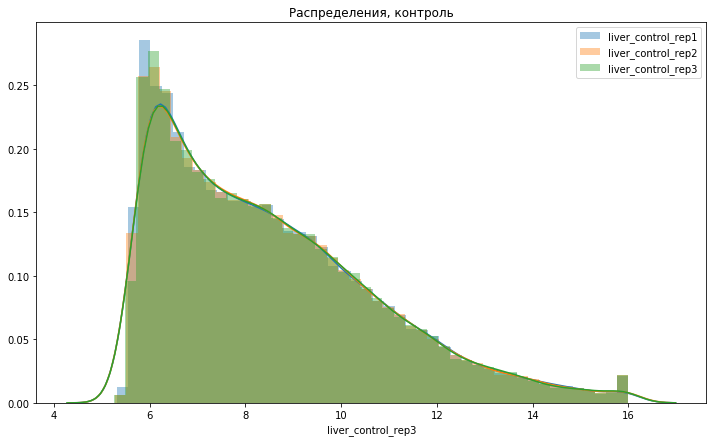

In [23]:
dist_plot(data, ['liver_control_rep1', 'liver_control_rep2', 'liver_control_rep3'] , 'контроль')

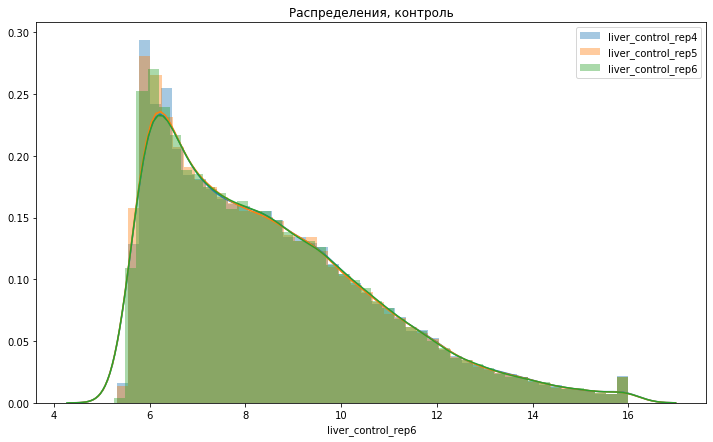

In [24]:
dist_plot(data, ['liver_control_rep4', 'liver_control_rep5', 'liver_control_rep6'] , 'контроль')

# Low dose

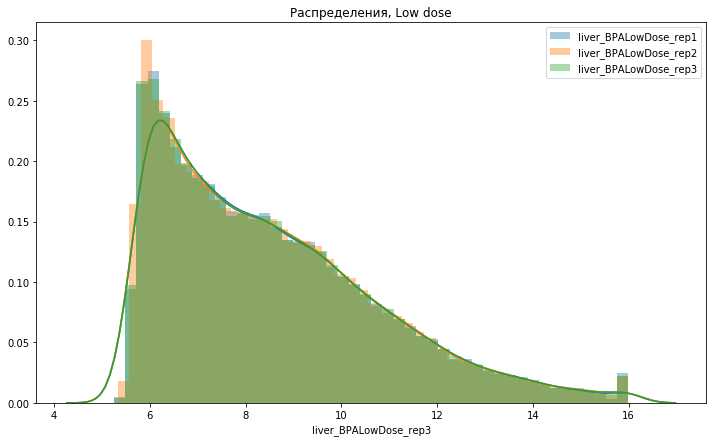

In [26]:
dist_plot(data, ['liver_BPALowDose_rep1', 'liver_BPALowDose_rep2', 'liver_BPALowDose_rep3'], 'Low dose')

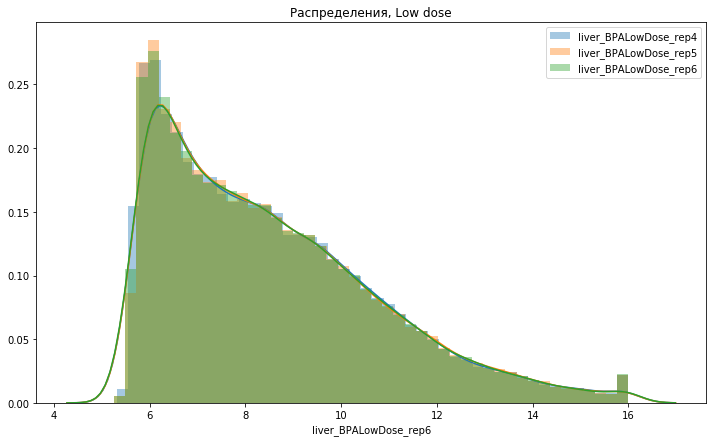

In [27]:
dist_plot(data, ['liver_BPALowDose_rep4', 'liver_BPALowDose_rep5', 'liver_BPALowDose_rep6'], 'Low dose')

# High dose

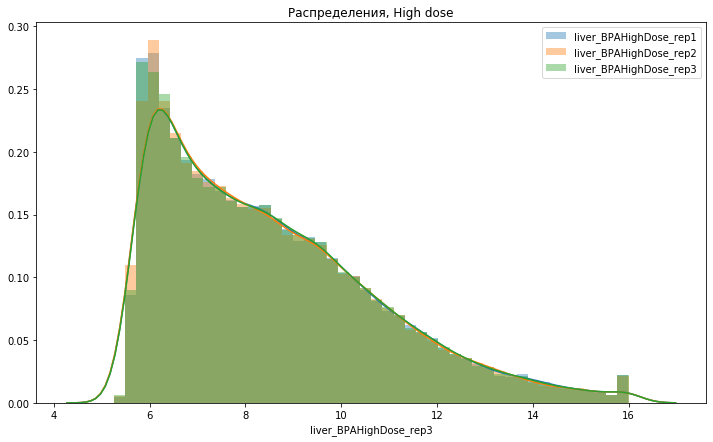

In [28]:
dist_plot(data, ['liver_BPAHighDose_rep1', 'liver_BPAHighDose_rep2', 'liver_BPAHighDose_rep3'], 'High dose')

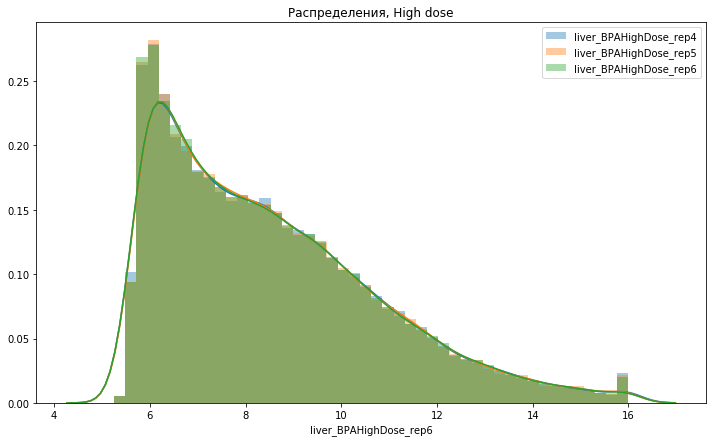

In [29]:
dist_plot(data, ['liver_BPAHighDose_rep4', 'liver_BPAHighDose_rep5', 'liver_BPAHighDose_rep6'], 'High dose')

# 2. Подсчет средних

Сперва усредним все значения между дубликатами (по каждому столбику отдельно). Нам это в любом случае пригодится, когда будем делать третье задание.

In [30]:
data = data.groupby(['Gene_ID']).mean()

In [31]:
data.head()

,liver_control_rep1,liver_control_rep2,liver_control_rep3,liver_control_rep4,liver_control_rep5,liver_control_rep6,liver_BPALowDose_rep1,liver_BPALowDose_rep2,liver_BPALowDose_rep3,liver_BPALowDose_rep4,liver_BPALowDose_rep5,liver_BPALowDose_rep6,liver_BPAHighDose_rep1,liver_BPAHighDose_rep2,liver_BPAHighDose_rep3,liver_BPAHighDose_rep4,liver_BPAHighDose_rep5,liver_BPAHighDose_rep6
Gene_ID,,,,,,,,,,,,,,,,,,
11287,15.624,15.444,14.9970,15.2540,15.6080,15.207,15.247,15.614,15.0180,15.314,15.501,15.4910,15.081,15.997,15.484,15.310,15.3370,14.982
11298,6.470,5.917,6.1420,6.3570,6.3340,5.527,5.882,5.393,6.5130,6.097,5.965,6.1230,6.268,5.913,6.061,6.507,5.9670,6.106
11302,7.755,7.628,7.7900,7.7940,7.8030,7.904,7.912,7.398,7.5500,7.502,7.678,7.2040,7.739,7.516,7.733,8.020,8.2370,7.927
11303,11.248,11.339,11.0730,11.2190,11.0800,11.452,11.630,11.921,11.5680,11.618,11.402,11.3810,11.497,12.071,11.332,11.897,11.6240,10.868
11305,8.447,8.979,8.6535,8.7735,8.1155,8.362,8.032,8.419,8.6255,8.802,8.290,8.6915,8.781,8.905,8.583,8.582,8.6875,8.598


Теперь посчитаем для каждого гена среднее в контроле, low dose и high dose.

In [32]:
control_columns = ['liver_control_rep1', 'liver_control_rep2',
       'liver_control_rep3', 'liver_control_rep4', 'liver_control_rep5',
       'liver_control_rep6']
low_BPA_columns = ['liver_BPALowDose_rep1', 'liver_BPALowDose_rep2',
       'liver_BPALowDose_rep3', 'liver_BPALowDose_rep4',
       'liver_BPALowDose_rep5', 'liver_BPALowDose_rep6']
high_BPA_columns = ['liver_BPAHighDose_rep1', 'liver_BPAHighDose_rep2',
       'liver_BPAHighDose_rep3', 'liver_BPAHighDose_rep4',
       'liver_BPAHighDose_rep5', 'liver_BPAHighDose_rep6']

In [33]:
def calc_mean(data, columns_to_mean, name):
    mean = data[columns_to_mean].mean(axis=1)
    return mean.to_frame(name)

In [34]:
control_mean = calc_mean(data, control_columns, 'control')
low_BPA_mean = calc_mean(data, low_BPA_columns, 'low_BPA')
high_BPA_mean = calc_mean(data, high_BPA_columns, 'high_BPA')

data_mean = control_mean.join([low_BPA_mean, high_BPA_mean])

In [35]:
data_mean.head()

,control,low_BPA,high_BPA
Gene_ID,,,
11287,15.355667,15.364167,15.365167
11298,6.124500,5.995500,6.137000
11302,7.779000,7.540667,7.862000
11303,11.235167,11.586667,11.548167
11305,8.555083,8.476667,8.689417


# 3. Дерево решений

## Что получилось:
* Есть проблема: мы не можем построить на всех фичах дерево высоты 2, получается лишь дерево высоты 1, так как дальшейшее разделение не приводит к уменьшению impurity(слишком много фичей, нужно уменьшать количество фичей, то есть переходить к random forest).
* В случае классификатора control vs low dose важным геном оказался 67894, а для классификатора control vs high dose --- 71385.

## 3.1 Готовим данные

In [36]:
def make_Xy(data, control_columns, BPA_columns):
    X_control = data[control_columns].transpose().to_numpy()
    X_BPA = data[BPA_columns].transpose().to_numpy()
    X = np.vstack((X_control, X_BPA))
    
    y = np.array(['control'] * len(X_control) + ['BPA'] * len(X_BPA))
    perm = np.random.permutation(len(X))
    return X[perm], y[perm]

In [37]:
X_low, y_low = make_Xy(data, control_columns, low_BPA_columns)
X_high, y_high = make_Xy(data, control_columns, high_BPA_columns)

Мы знаем, что для деревьев нормирование данных не требуется, поэтому будем использовать прямо эти датасеты.

## 3.2 Важность в low dose

[Text(167.4, 163.07999999999998, 'X[6131] <= 9.459\ngini = 0.5\nsamples = 12\nvalue = [6, 6]'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]')]

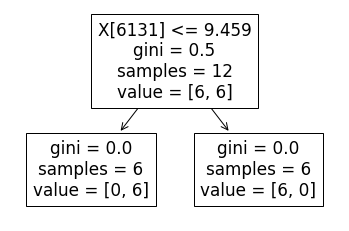

In [38]:
clf = DecisionTreeClassifier(max_depth=2, random_state=0, min_impurity_decrease=0)
clf.fit(X_low, y_low)
plot_tree(clf)

In [39]:
data.iloc[[6131], :]

,liver_control_rep1,liver_control_rep2,liver_control_rep3,liver_control_rep4,liver_control_rep5,liver_control_rep6,liver_BPALowDose_rep1,liver_BPALowDose_rep2,liver_BPALowDose_rep3,liver_BPALowDose_rep4,liver_BPALowDose_rep5,liver_BPALowDose_rep6,liver_BPAHighDose_rep1,liver_BPAHighDose_rep2,liver_BPAHighDose_rep3,liver_BPAHighDose_rep4,liver_BPAHighDose_rep5,liver_BPAHighDose_rep6
Gene_ID,,,,,,,,,,,,,,,,,,
67894,9.003,9.158,9.422,9.216,8.818,9.326,9.609,9.514,9.497,9.527,9.682,10.05,9.307,9.408,9.629,9.414,9.145,9.256


Это ген 67894

## 3.3 Важность в high dose

[Text(167.4, 163.07999999999998, 'X[7146] <= 7.172\ngini = 0.5\nsamples = 12\nvalue = [6, 6]'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]')]

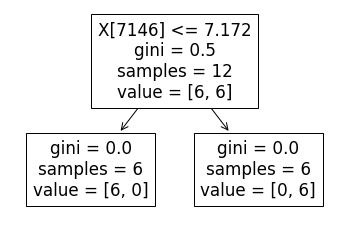

In [40]:
clf = DecisionTreeClassifier(max_depth=2, random_state=0, min_impurity_decrease=0)
clf.fit(X_high, y_high)
plot_tree(clf)

In [41]:
data.iloc[[7146], :]

,liver_control_rep1,liver_control_rep2,liver_control_rep3,liver_control_rep4,liver_control_rep5,liver_control_rep6,liver_BPALowDose_rep1,liver_BPALowDose_rep2,liver_BPALowDose_rep3,liver_BPALowDose_rep4,liver_BPALowDose_rep5,liver_BPALowDose_rep6,liver_BPAHighDose_rep1,liver_BPAHighDose_rep2,liver_BPAHighDose_rep3,liver_BPAHighDose_rep4,liver_BPAHighDose_rep5,liver_BPAHighDose_rep6
Gene_ID,,,,,,,,,,,,,,,,,,
71385,7.376,7.231,7.248,7.352,7.786,7.271,6.699,7.268,7.256,6.839,7.082,7.081,6.799,6.94,6.923,7.047,6.966,7.114


Это ген 71385